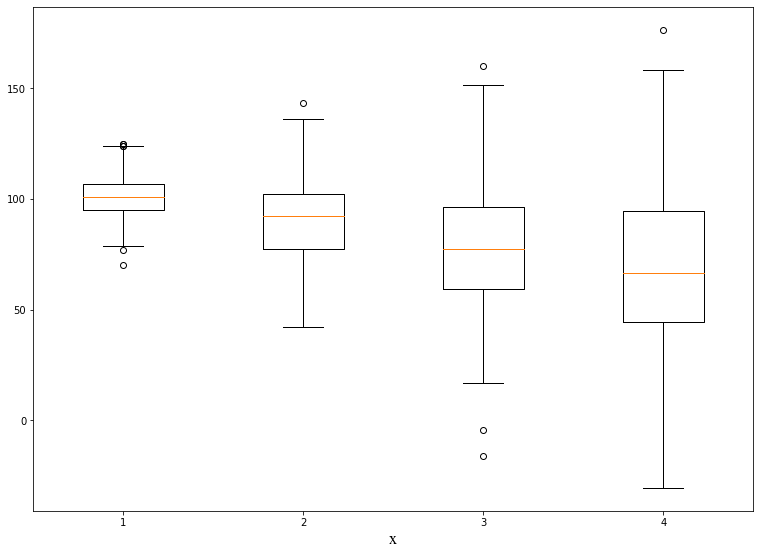

In [7]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

font = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        } 
 
# Creating dataset
np.random.seed(10)
 
data_1 = np.random.normal(100, 10, 200)
data_2 = np.random.normal(90, 20, 200)
data_3 = np.random.normal(80, 30, 200)
data_4 = np.random.normal(70, 40, 200)
data = [data_1, data_2, data_3, data_4]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
plt.xlabel('Instance Size', fontdict=font)
plt.ylabel('Computing time', fontdict=font)

# show plot
fig.savefig("out.svg", bbox_inches="tight", pad_inches=0)
fig.savefig("test.svg", format="svg")
plt.show()